# Binary Classification of Brain Tumours using a Support Vector Machine (SVM) with SIFT feature extraction and k-Means clustering.

For more information on the background of this notebook, please see README.md and the supplementary report.

In [27]:
# Utility libraries
%matplotlib inline
from IPython.display import clear_output
import os
import pickle
import time
import math
import numpy as np
import matplotlib.pyplot as plt

# Machine learning and image management libraries
import cv2
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

The cell below defines key constants of the notebook below. These are free to be changed.

The data is loaded from locations relative this directory. Change the dataset location as necessary below.
The below two cells work under the assumption that the filenames and labels located in 'label.csv' exactly match the images found in the 'images' directory, for both the dataset and the external test set.

In [28]:

# First is a directory containing the images themselves.
# Second is a csv file containing filenames and labels.
TRAINING_LOCATION = "..\\..\\assignment_kit\\dataset\\images\\"
TRAINING_LABEL_LOCATION = "..\\..\\assignment_kit\\dataset\\label.csv"

# First is a directory containing the images themselves.
# Second is a csv file containing filenames and labels.
TEST_LOCATION = "..\\..\\assignment_kit\\test_set\\images\\"
TEST_LABEL_LOCATION = "..\\..\\assignment_kit\\test_set\\label.csv"

# The directory in which to store pre-processed images, or the directoy in which
# pre-processed images will be found if they have already been pre-processed.
PROCESSED_TRAINING_LOCATION = "..\\..\\assignment_kit\\dataset\\processed_images\\"
PROCESSED_TEST_LOCATION = "..\\..\\assignment_kit\\test_set\\processed_images\\"

# Locations and directories to save data produced by the notebook
DATA_SAVE_LOCATION = "..\\SVM_SFT_saved_data\\"
TRAINING_DESCRIPTOR_FILENAME = "training_descriptors.npy"
TRAINING_NUM_KEY_POINTS_LIST_FILENAME = "training_num_key_points.npy"
TEST_DESCRIPTOR_FILENAME = "test_descriptors.npy"
TEST_NUM_KEY_POINTS_LIST_FILENAME = "test_num_key_points.npy"
# Flags to change operation of notebook. Flag names are informative.
EXTRACT_TRAINING_FEATURES_EVEN_IF_EXTRACTED_BEFORE = False
EXTRACT_TEST_FEATURES_EVEN_IF_EXTRACTED_BEFORE = False
SAVE_TRAINING_DESCRIPTORS = True
SAVE_TEST_DESCRIPTORS = True
FIND_K_MEANS_CLUSTERS_EVEN_IF_FOUND_BEFORE = False
SAVE_K_MEANS_INSTANCES = True
K_MEANS_FILENAME_POSTAMBLE = "_kmeans.pkl"          # Forexample, for k = 50, sklearn.cluster.KMeans instance will be saved as "50_kmeans.pkl".
K_MEANS_NUMBER_OF_RUNS = 3                          # Per K value
K_MEANS_MAX_ITERATIONS = 200                        # Per run per K value. Algorithm will return anyway if it converges within the default tolerance.
K_MEANS_VERBOSE_LEVEL = 6                           # Set this is 0 for no output, 6 for max output.
K_FOLD_CROSS_VALIDATION_K = 10                      # The number of folds used in K fold validation. THIS IS VERY DIFFERENT FROM THE K VALUE IN K MEANS CLUSTERING.
C_SECOND_SWEEP_RANGE = range(10, 100)

# The below define the values of various model hyperparameters to try

# k values for k-means clustering. STOP is not inclusive hence increment it by STEP to ensure it is in included.
K_VALS = np.arange(20, 80 + 10, 10).tolist()

# SVM regularisation parameter C = 1 / \lambda. Different orders of magnitude of C are tried
C_VALS = np.linspace(0.001, 0.01, 10).tolist() + np.linspace(0.01, 0.1, 10).tolist()

# Degeree of polynomial kernel. Degree = 1 is a linear kernel.
POLY_KERNEL_DEGREES = range(1, 13) # Tried degrees 1 to 12.

# Gaussian sigmas of RBF kernels
RBF_KERNEL_SIGMAS = np.linspace(0.0001, 0.001, 2).tolist() + np.linspace(0.001, 0.01, 2).tolist() + np.linspace(0.01, 0.1, 2).tolist() + np.linspace(1, 10, 2).tolist() + np.linspace(10, 100, 2).tolist()

# These 'sensible' values are used in the process of optimising the hyperparameters
SENSIBLE_C = 0.01
SENSIBLE_KERNEL = "poly"
SENSIBLE_KERNEL_PARAMETER = 6 # For the polynomial kernel, the parameter it its degree

if (SAVE_TRAINING_DESCRIPTORS or SAVE_TEST_DESCRIPTORS):
    if not os.path.isdir(DATA_SAVE_LOCATION):
        os.mkdir(DATA_SAVE_LOCATION)

print("#K_VALS = {}. K_VALS = {}.".format(len(K_VALS), K_VALS))
print("#C_VALS = {}. C_VALS = {}.".format(len(C_VALS), [float("%.4f" % C) for C in C_VALS]))

#K_VALS = 7. K_VALS = [20, 30, 40, 50, 60, 70, 80].
#C_VALS = 20. C_VALS = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1].


In [3]:
# Loads data into numpy array of strings.
# Header is skipped as given by skip_header = 1.
# The header in the expected file is "file_name" and "label".
# Therefore, indexing the 0'th element in a row references the filenames and indexing the 1'th element in a row references the label

data = np.genfromtxt(TRAINING_LABEL_LOCATION, delimiter = ',', dtype = str, skip_header = 1)

num_images = data.shape[0]

# As this a binary classification task, we can rename all labels which are not 'no_tumor' to 'tumor'.
# This will prevent many further comparisons in future.
for i in range(num_images):
    if (data[i][1] != "no_tumor"):
        data[i][1] = "tumor"

# For later ease, we process and store the second column of data (the data labels) as below
training_labels = [1 if (label == "tumor") else 0 for label in data[:,1]]

print("There are {} images in the dataset.".format(num_images))

There are 3000 images in the dataset.


## Data Pre-Processing

The images in the dataset are given as RGB images. This means that each pixel has three corresponding values due to the three colour channels. In the analysis given here, only the greyscale images are needed. That is, each pixel only has one corresponding due to the single colour channel. To enforce this, we pre-process the images to save them in greyscale format. These are then saved in an alternate directory as given by `PROCESSED_TRAINING_LOCATION`.

Additionally, the SIFT functionality as implemented by `sklearn` only accepts single colour channel images of unsigned 8 bit datatype. Therefore, the images formed below are normalised as such. Min-Max normalisation here is used with relative safety as much of the dataset does not include spikes in intensity that would force the normaliser to fully normalise any details away. However, this method can lead to some images in the dataset being more 'illuminated' than others. Even though this is the nature of the un-pre-processed dataset anyways, fortunately the SIFT feature detection method is robust to illumination variation.

To ensure that the images are read correctly after they have been processed, the flag `cv2.IMREAD_GRAYSCALE` must be passed when calling `cv2.imread( ... )`.

In [4]:
if not (os.path.isdir(PROCESSED_TRAINING_LOCATION)):
    os.mkdir(PROCESSED_TRAINING_LOCATION)

    for i in range(num_images):
        image_string = "IMAGE_" + str(i).zfill(4)
        
        image = cv2.imread(TRAINING_LOCATION + image_string + ".jpg")
        
        # Convert colour image to greyscale
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Normalise image such that pixel values are unsigned 8 bit
        processed_image = cv2.normalize(grey_image, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
        
        cv2.imwrite(PROCESSED_TRAINING_LOCATION + image_string + ".jpg", processed_image)
        
        if (i % 100 == 0):
            clear_output(wait = True)
            print("{} / {} images processed.".format(i, num_images))
    
    clear_output(wait = True)
    print("Image processing done! {} images were processed!".format(num_images))
    
else:
    print("Data has already been pre-processed!")

Data has already been pre-processed!


Now, we output some random examples from the dataset just to visualise what we are working with. Feel free to run the cell multiple times to see more images in the dataset.

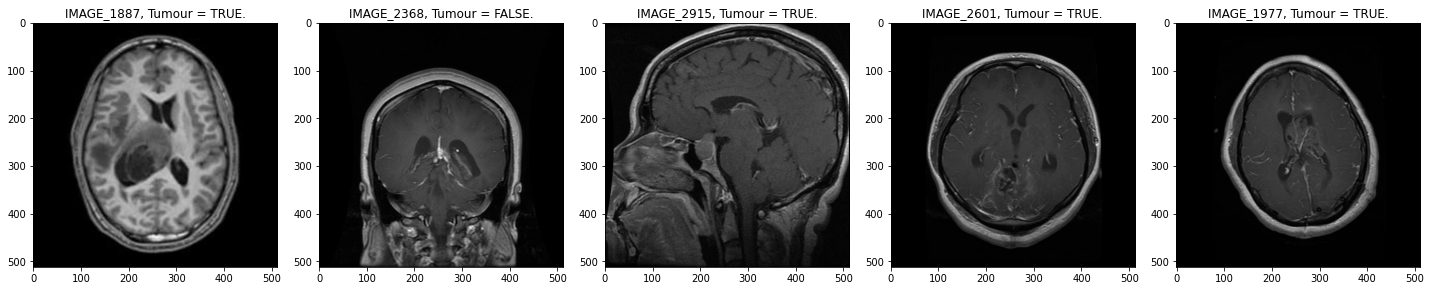

In [5]:
fig, ax = plt.subplots(1, 5, figsize = (20, 4))

for i in range(5):
    image_num = np.random.randint(0, num_images - 1)
    image_string = "IMAGE_" + str(image_num).zfill(4)
    
    ax[i].imshow(cv2.imread(PROCESSED_TRAINING_LOCATION + image_string + ".jpg", cv2.IMREAD_GRAYSCALE), cmap = "gray")
    ax[i].set_title("{}, Tumour = {}.".format(image_string, "TRUE" if (data[i][1] != "no_tumor") else "FALSE"))
    
plt.tight_layout()

## SIFT Feature Extraction and Compilation

Here, the SIFT framework is used to extract SIFT keypoints and their corresponding descriptors from the images in the dataset.

There are a few free/hyper parameters that are available for exploration. These parameters include the SIFT parameters: the number of octaves, the number of scale levels, the standard deviation used in the Laplacian of Gaussian (LoG) operation $\sigma$, and others. Another hyperparameter is the number of centroids/cluster's provided to the k-Means clustering algorithm $K$. This hyperparameter $K$ is the only hyperparameter explored here due to the SIFT parameters exerting significantly less influence on the final accuracy when compared to $K$.

ALL SIFT features extracted from the training set images are used. This may seem excessive however this is deemed possible with the help of a brief calculation, as follows. The 3000 images in the dataset appear to have an average of 1000 features (empircally found). The descriptor for each feature is 128 dimensional vector with each entry being an unsigned integer small enough to fit inside an unsigned byte representation - 8 bits. Therefore, the minimum memory requirement for storing the feature descriptors for future k-means clustering can be justified to be $3000 \times 1000 \times 128 \times 8 \approx 3 \times 10^{9}$ bits. This is approximately 300 megabytes. This is well within the memory capabilities of most modern machines even if the language used is Python which of course it is here.

As will be seen later on, we need to keep track of how many features are found in each image. To do this, we intialise the list below and append to it in `build_set` which is defined further below. This is done such that the number of features found in image $n$ is `num_key_points_list[n]`. Remember, this if for the TRAINING SET only.

In [6]:
# See markdown cell above for documentation.
num_key_points_list = np.zeros(num_images, dtype = np.uint)

We now show an example image and the features extracted from it.

1038 key points found in example image "IMAGE_1834".
For example, key point 335 of the image is represented by the following descriptor vector:
[  2  16   1   0   4   2   0   2  75 124   2   0   0   0   0   2 146 147
   7   0   0   0   0  23  71  63   6  17  22   6   0  21   1   0   0   0
   1   7  11  11 131  14   0   0   0   1   4  12 147  17   2   3   0   0
   0 101  77   4   5 105  31   2   0  61   0   0   0   1   8  36  11   4
 110   7   0   1   1   3   7  13 147 101  36  27   0   0   0  12  24  21
  63 147  12   0   0   3   0   0   0   0   7  53  41   0  20  11   3   4
  12  15  38  11  41 118  58  18   2   1   1   2   1  15  50 106   7   1
   0   0]


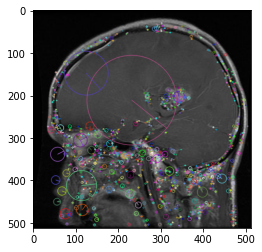

In [7]:
sift = cv2.SIFT_create()

image_string = "IMAGE_" + str(np.random.randint(0, num_images - 1)).zfill(4)
image = cv2.imread(PROCESSED_TRAINING_LOCATION + image_string + ".jpg", cv2.IMREAD_GRAYSCALE)

key_points, descriptors = sift.detectAndCompute(image, None)
descriptors = descriptors.astype(np.ubyte)

image = cv2.drawKeypoints(image, key_points, image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print("{} key points found in example image \"{}\".".format(len(key_points), image_string))

example_desc_num = np.random.randint(0, len(key_points))
print("For example, key point {} of the image is represented by the following descriptor vector:".format(example_desc_num))
print(descriptors[example_desc_num])

plt.imshow(image)

Now we proceed with building the entire dataset.

In [8]:

def build_set(data_, filename, set_num_list):
    # Given a (N \times 2) numpy array with the first column containing the filenames of the images
    # and the second row containing the images labels (as given with the data for this task),
    # this function returns a list of the descriptors of the features found from images in the dataset.
    # The array desc_set is re-sized for every image which makes this function fairly clunky. However, this is
    # by far the simplest method to implement it. An attempt was made to implement it by estimating the total number
    # of descriptors to prevent frequent re-allocation but in the end Occam's razor prevails.
    
    # Parameter data_ is named as such to prevent confusion with the global 'data' used elsewhere in this notebook.
    # The filename parameter is the filename to save the found dataset as. It should end with the extension .npy.
    
    print("Beginning feature extraction and computation...")
    
    sift = cv2.SIFT_create()
    
    desc_set = np.empty((0, 128), dtype = np.ubyte)
    
    for i in range(data_.shape[0]):
        
        if ((i % 100 == 0) and (i != 0)):
            clear_output(wait = True)
            print("Features extracted and processed from {} images (there are {} total).".format(i, data_.shape[0]))
        
        image = cv2.imread(PROCESSED_TRAINING_LOCATION + "IMAGE_" + str(i).zfill(4) + ".jpg", cv2.IMREAD_GRAYSCALE)
        
        _, descriptors = sift.detectAndCompute(image, mask = None)
        
        descriptors = descriptors.astype(np.ubyte)
        
        # Take note of how many key points were found
        set_num_list[i] = len(descriptors)
        
        desc_set = np.append(desc_set, descriptors, axis = 0)
    
    clear_output(wait = True)
    print("Finished building {}!".format(filename))
    
    # Save generated description set if told to
    if (SAVE_TRAINING_DESCRIPTORS):
        np.save(DATA_SAVE_LOCATION + filename, desc_set)
        print("{} successfully saved.".format(DATA_SAVE_LOCATION + filename))
    
    return desc_set

In [9]:
if (EXTRACT_TRAINING_FEATURES_EVEN_IF_EXTRACTED_BEFORE):
    descriptor_training_set = build_set(data, TRAINING_DESCRIPTOR_FILENAME, num_key_points_list)

    # Save num_key_points_list so it can be loaded in later runs
    if (SAVE_TRAINING_DESCRIPTORS):
        np.save(DATA_SAVE_LOCATION + TRAINING_NUM_KEY_POINTS_LIST_FILENAME, num_key_points_list)
        print("{} successfully saved.".format(DATA_SAVE_LOCATION + TRAINING_NUM_KEY_POINTS_LIST_FILENAME))
    
else:
    # Attempt to load previous pre-processed training set
    try:
        descriptor_training_set = np.load(DATA_SAVE_LOCATION + TRAINING_DESCRIPTOR_FILENAME)
        print("Descriptor training set successfully loaded from {}.".format(DATA_SAVE_LOCATION + TRAINING_DESCRIPTOR_FILENAME))
        
    except FileNotFoundError:
        print("Descriptor training set could not be loaded from {}.".format(DATA_SAVE_LOCATION + TRAINING_DESCRIPTOR_FILENAME))
        
        descriptor_training_set = build_set(data, TRAINING_DESCRIPTOR_FILENAME, num_key_points_list)

        # Save num_key_points_list so it can be loaded in later runs
        if (SAVE_TRAINING_DESCRIPTORS):
            np.save(DATA_SAVE_LOCATION + TRAINING_NUM_KEY_POINTS_LIST_FILENAME, num_key_points_list)
            print("{} successfully saved.".format(DATA_SAVE_LOCATION + TRAINING_NUM_KEY_POINTS_LIST_FILENAME))

# For code convenience and for sanity checking, re-load the saved num_key_points_list
num_key_points_list = np.load(DATA_SAVE_LOCATION + TRAINING_NUM_KEY_POINTS_LIST_FILENAME)
print("The numpy array num_key_points_list was succesfully loaded from {}.".format(DATA_SAVE_LOCATION + TRAINING_NUM_KEY_POINTS_LIST_FILENAME))

print("\nFor sanity checking, the shape of the descriptor training set numpy array is ({}, {}).".format(descriptor_training_set.shape[0], descriptor_training_set.shape[1]))

Descriptor training set successfully loaded from ..\SVM_SFT_saved_data\training_descriptors.npy.
The numpy array num_key_points_list was succesfully loaded from ..\SVM_SFT_saved_data\training_num_key_points.npy.

For sanity checking, the shape of the descriptor training set numpy array is (2717148, 128).


## Using k-Means Clustering to Produce a "Visual Vocabulary"

If running from a complete cold start, this is the section of the notebook that takes the longest time. This section can take up to an hour. Therefore, data is saved from previous runs (if the correct flag is set). If the program senses saved data from previous runs, it will attempt to load it - this saves the user a LOT of time. REMEMBER: k-means clustering is NOT deterministic hence the 'kmeans' instances will be the same as the last run if loaded but NOT be the same if re-computed. Therefore, for further randomness, the k-Means clustering should be re-run.

In [10]:
def find_k_means_clusters(k, desc_set):
    # Parameter desc_set is the training/test set being a numpy array containing all the
    # SIFT descriptors for the SIFT features found in ALL of the dataset, be it training or test.

    print("Beginning k-Means clustering for k = {}. There will be {} runs.".format(k, K_MEANS_NUMBER_OF_RUNS))
    print("(Initialisation can take up to two minutes for each run).")

    # Initialise kMeans class instance
    kmeans = KMeans(
        n_clusters = k,
        init = "k-means++",
        n_init = K_MEANS_NUMBER_OF_RUNS,
        max_iter = K_MEANS_MAX_ITERATIONS,
        verbose = K_MEANS_VERBOSE_LEVEL
    )
    
    # Run the k-means clustering algorithm
    kmeans.fit(desc_set)
    
    clear_output(wait = True)
    print("Finished building and fitting kmeans instance for k = {}.".format(k))
    
    # Save the kmeans object using the pickle library
    if (SAVE_K_MEANS_INSTANCES):
        pickle.dump(kmeans, open(DATA_SAVE_LOCATION + str(k) + K_MEANS_FILENAME_POSTAMBLE, "wb"))
        print("{} successfully saved.".format(DATA_SAVE_LOCATION + str(k) + K_MEANS_FILENAME_POSTAMBLE))
    
    return kmeans

In [11]:
k_means_instances = {}

for k in K_VALS:
    
    # If k_means_instances dictionary is already partially populated, display what has already been found.
    if (k != K_VALS[0]):
        clear_output(wait = True)
        print("Have already fitted/loaded kmeans instances for k = {}.\n".format(str(list(k_means_instances))))
    
    if (FIND_K_MEANS_CLUSTERS_EVEN_IF_FOUND_BEFORE):
        kmeans = find_k_means_clusters(k, descriptor_training_set)
    else:
        # Attempt to load previously found kmeans centres
        try:
            kmeans = pickle.load(open(DATA_SAVE_LOCATION + str(k) + K_MEANS_FILENAME_POSTAMBLE, "rb"))
            print("KMeans instance SUCCESSFULLY loaded from {}.".format(DATA_SAVE_LOCATION + str(k) + K_MEANS_FILENAME_POSTAMBLE))
            
        except FileNotFoundError:
            print("KMeans instance COULD NOT be loaded from {}.".format(DATA_SAVE_LOCATION + str(k) + K_MEANS_FILENAME_POSTAMBLE))
            
            kmeans = find_k_means_clusters(k, descriptor_training_set)
    
    # With kmeans instance either loaded or fitted, store the instance in the k_means_instances dictionary.
    # Remember, a fitted kmeans instance contains the cluster centres amongst other important attributes.
    k_means_instances[k] = kmeans

clear_output(wait = True)
print("Finished! Instances of kmeans have been fitted/loaded for k = {}.".format(str(list(k_means_instances))))

Finished! Instances of kmeans have been fitted/loaded for k = [20, 30, 40, 50, 60, 70, 80].


## Building Feature Vector Dataset for all K

With our "visual vocabularies" for various $k$ produced, we next need to translate our image dataset into frequency histograms with bases defined by the k-Means clustering as above. To do this, we load are visual vocabulary and classify the SIFT features into these 'word' categories. The frequency of the occurance of each 'word' in each image is stored such that a histogram storing the frequency of occurance of each 'word' is yielded. The procedure just described is carried out for ALL $k$ such that the multiple sets of training histograms are stored in `all_training_hists`. That way, the correct size training set can be retrieved by using `all_training_hists[k]`.

In [12]:
all_training_hists = {}

print("Beginning process of translating clustered descriptor sets into feature vectors for every image for all k...")
time.sleep(5) # Give user time to read above message

for k_index, k in enumerate(K_VALS):
    
    # Initialise empty array in which to store the found histograms for each image
    training_hists = np.zeros((num_images, k), dtype = float)
    
    # Helps in slicing descriptor_training_set
    slice_start = 0
    slice_stop = num_key_points_list[0]

    for i in range(num_images - 1):
        # Slice descriptor slicing set correctly and put cluster count in hist which is of length k.
        hist = np.bincount(k_means_instances[k].predict(descriptor_training_set[slice_start:slice_stop]), minlength = k)
        
        training_hists[i] = hist
        
        slice_start = slice_stop
        slice_stop += num_key_points_list[i + 1]
        
        if (i % 100 == 0):
            clear_output(wait = True)
            print("Descriptor collections corresponding to {} images processed for k = {} ({} out of {} k values considered).".format(i, k, k_index + 1, len(K_VALS)))

    # Do last element separately to ensure an array addressing error is avoided
    hist  = np.bincount(k_means_instances[k].predict(descriptor_training_set[slice_start:]), minlength = k)
    training_hists[-1] = hist
    
    # Store training hists for this k in all_training_hists
    all_training_hists[k] = training_hists

clear_output(wait = True)
print("Finished! {} descriptor collections processed for {} k values, all normalised and stored in all_training_hists.".format(num_images, len(K_VALS)))


Finished! 3000 descriptor collections processed for 7 k values, all normalised and stored in all_training_hists.


## Evaluating Model Performance with Cross-Validation and Hyperparameter Tuning

**Hindsight**: Optimising all of these parameters lead to dramatic overfitting! The parameter most liable for this is the degree of the polynomial kernel. It turns out that the best kernel to use in this case was a polynomial kernel of order one - a linear kernel! The overfitting procedure implemented in the below cells is left for a reader to view. This has turned out to be a good example of the mechanics of overfitting and leads to some interesting discussion in the corresponding report.

**FURTHER Hindsight**: It turns out that the model with the highest accuracy is one that guesses that there is a tumour in each image! This is because about 80% of the images in the dataset contain a tumour. The best performing model when tested on the test set turns out to be a polynomial kernel model.

The hyperparameters to consider are the number of clusters $k$, the regularisation parameter $C$ and the kernel used when fitting the SVM. The kernels to consider are polynomial kernels of various degree (degree one corresponds to a third type of common kernel - linear) and Radial Basis Function (RBF) (Gaussian) kernels of varying $\sigma$. The latter will be compared to the "auto" $\sigma$ value generated by sklearn.

The default value for `K_FOLD_CROSS_VALIDATION_K` provided with this notebook is 10. This ensures that 10 fold cross validation is carried out. In that process, each validation set used is of size 3000 / 10 = 300.

In [29]:
# The next step is to find the optimal configuration of the hyperparameters. This will NOT be an exhaustive search due to computing and time contraints.
# Instead, a good approximation of this should be to find the best value for each hyperparameter using 'sensible' values of other hyperparameters.

optimal_hyperparameters = {
    "k" : 0,
    "c" : 0,
    "kernel" : "",
    "kernel_parameter" : 0 # Describes degree if kernel is polynomial, sigma is RBF
}

optimal_scores = {
    "k" : 0.0,
    "c" : 0.0,
    "poly" : 0.0,
    "rbf" : 0.0,
}

k_scores = {}
c_scores = {}
poly_scores = {}
rbf_scores = {}

In [30]:
# Find the (probably) optimal k value from the k values considered before
for k_index, k in enumerate(K_VALS):
    
    clear_output(wait = True)
    print("Testing hyperparameter k = {}. ({} / {})".format(k, k_index + 1, len(K_VALS)))
    
    svc = SVC(C = SENSIBLE_C, kernel = SENSIBLE_KERNEL, degree = SENSIBLE_KERNEL_PARAMETER)
    k_scores[k] = round(sum(cross_val_score(svc, all_training_hists[k], training_labels, cv = K_FOLD_CROSS_VALIDATION_K)) / K_FOLD_CROSS_VALIDATION_K, 5)
    
    if (k_scores[k] > optimal_scores["k"]):
        optimal_scores["k"] = k_scores[k]
        optimal_hyperparameters["k"] = k
        
# Report results
clear_output(wait = True)
print("Optimal k value found is {} with a cross-validation score (accuracy) of {}.".format(optimal_hyperparameters["k"], optimal_scores["k"]))
print("All the scores found the various k values are as follows:")
print(k_scores)

Optimal k value found is 50 with a cross-validation score (accuracy) of 0.926.
All the scores found the various k values are as follows:
{20: 0.91367, 30: 0.919, 40: 0.92467, 50: 0.926, 60: 0.92367, 70: 0.922, 80: 0.922}


In [31]:
# Find the (probably) optimal regularisation parameter C
for c_index, c in enumerate(C_VALS):
    
    clear_output(wait = True)
    print("Testing hyperparameter C = {}. ({} / {})".format(round(c, 5), c_index + 1, len(C_VALS)))
    
    svc = SVC(C = c, kernel = SENSIBLE_KERNEL, degree = SENSIBLE_KERNEL_PARAMETER)
    c_scores[c] = round(sum(cross_val_score(svc, all_training_hists[optimal_hyperparameters["k"]], training_labels, cv = K_FOLD_CROSS_VALIDATION_K)) / K_FOLD_CROSS_VALIDATION_K, 5)
    
    if (c_scores[c] > optimal_scores["c"]):
        optimal_scores["c"] = c_scores[c]
        optimal_hyperparameters["c"] = c
        
# Report results
clear_output(wait = True)
print("Optimal C value for optimal k = {} is {} with a score of {}.".format(optimal_hyperparameters["k"], optimal_hyperparameters["c"], optimal_scores["c"]))

Optimal C value for optimal k = 50 is 0.08 with a score of 0.93267.


In [32]:
# With near optimal k and c values found, next we need to evaluate which of two of the most common SVM kernels are most effective.
# We also need to work out the parameter at which that kernel is most effective.

# First, we try the polynomial kernel. Within this, a linear kernel is also tried (polynomial of order one)
for deg_index, deg in enumerate(POLY_KERNEL_DEGREES):
    
    clear_output(wait = True)
    print("Testing polynomial kernel of degree {} for k = {} and C = {}. ({} / {})".format(deg, optimal_hyperparameters["k"], optimal_hyperparameters["c"], deg_index, len(POLY_KERNEL_DEGREES)))
    
    svc = SVC(C = optimal_hyperparameters["c"], kernel = "poly", degree = deg)
    poly_scores[deg] = round(sum(cross_val_score(svc, all_training_hists[optimal_hyperparameters["k"]], training_labels, cv = K_FOLD_CROSS_VALIDATION_K)) / K_FOLD_CROSS_VALIDATION_K, 5)
    
    if (poly_scores[deg] > optimal_scores["poly"]):
        optimal_scores["poly"] = poly_scores[deg]

# Next we try the RBF with paramater sigma
for sigma_index, sigma in enumerate(RBF_KERNEL_SIGMAS):
    
    clear_output(wait = True)
    print("Testing RBF kernel of sigma {} for k = {} and C = {}. ({} / {})".format(round(sigma, 5), optimal_hyperparameters["k"], optimal_hyperparameters["c"], sigma_index + 1, len(RBF_KERNEL_SIGMAS)))
    
    svc = SVC(C = optimal_hyperparameters["c"], kernel = "rbf", gamma = sigma)
    rbf_scores[sigma] = round(sum(cross_val_score(svc, all_training_hists[optimal_hyperparameters["k"]], training_labels, cv = K_FOLD_CROSS_VALIDATION_K)) / K_FOLD_CROSS_VALIDATION_K, 5)
    
    if (rbf_scores[sigma] > optimal_scores["rbf"]):
        optimal_scores["rbf"] = rbf_scores[sigma]

# With all kernel configs tried, find the best one
if (optimal_scores["poly"] > optimal_scores["rbf"]):
    optimal_hyperparameters["kernel"] = "poly"
    optimal_hyperparameters["kernel_parameter"] = max(poly_scores, key = poly_scores.get)
else:
    optimal_hyperparameters["kernel"] = "rbf"
    optimal_hyperparameters["kernel_parameter"] = max(rbf_scores, key = rbf_scores.get)

clear_output(wait = True)

print("The most optimal kernel was found to be {} with degree/sigma of {} for k = {} and C = {}.".format(optimal_hyperparameters["kernel"], optimal_hyperparameters["kernel_parameter"], optimal_hyperparameters["k"], optimal_hyperparameters["c"]))
print("The best scores for both kernels were as follows:")
print("POLY: degree = {}, score = {}.".format(max(poly_scores, key = poly_scores.get), optimal_scores["poly"]))
print("RBF: sigma = {}, score = {}.".format(max(rbf_scores, key = rbf_scores.get), optimal_scores["rbf"]))

The most optimal kernel was found to be poly with degree/sigma of 7 for k = 50 and C = 0.08.
The best scores for both kernels were as follows:
POLY: degree = 7, score = 0.93433.
RBF: sigma = 0.0001, score = 0.87367.


In [33]:
# For experimentation, sigmas investigated are compared to the "auto" sigma generated by sklearn which is equal to 1 / n_features = 1 / k
# For the optimal k = 40, sigma = 1 / 40 = 0.025.

[print(round(key, 8),':',value) for key, value in rbf_scores.items()]

print("======================================================")

# Comparisation to auto version (sigma = 0.025)
svc = SVC(C = optimal_hyperparameters["c"], kernel = "rbf", gamma = "auto")
print("Score when using auto sigma (1 / optimal_k): {}.".format(round(sum(cross_val_score(svc, all_training_hists[optimal_hyperparameters["k"]], training_labels, cv = K_FOLD_CROSS_VALIDATION_K)) / K_FOLD_CROSS_VALIDATION_K, 5)))

0.0001 : 0.87367
0.001 : 0.84867
0.01 : 0.84867
0.1 : 0.84867
1.0 : 0.84867
10.0 : 0.84867
100.0 : 0.84867
Score when using auto sigma (1 / optimal_k): 0.84867.


## Testing the Optimal Model found on Unseen Test Data

First we load and pre-process the data in the exact same fashion as the training set. We then build various models with the `build_model()` function to test contructed models against test data.

In [34]:
# First, load the test data in the same way as the test data

test_data = np.genfromtxt(TEST_LABEL_LOCATION, delimiter = ',', dtype = str, skip_header = 1)

num_test_images = test_data.shape[0]

test_labels = [0 if (label == "no_tumor") else 1 for label in test_data[:,1]]

print("There are {} images in the test set.".format(num_test_images))

There are 200 images in the test set.


In [35]:
# As before, save images as greyscale only - one colour channel.

if not (os.path.isdir(PROCESSED_TEST_LOCATION)):
    os.mkdir(PROCESSED_TEST_LOCATION)

    for i in range(num_test_images):
        image_string = "IMAGE_" + str(i).zfill(4)
        
        image = cv2.imread(TEST_LOCATION + image_string + ".jpg")
        
        # Convert colour image to greyscale
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Normalise image such that pixel values are unsigned 8 bit
        processed_image = cv2.normalize(grey_image, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
        
        cv2.imwrite(PROCESSED_TEST_LOCATION + image_string + ".jpg", processed_image)
        
        if (i % 10 == 0):
            clear_output(wait = True)
            print("{} / {} images processed.".format(i, num_test_images))
    
    clear_output(wait = True)
    print("Image processing done! {} images were processed!".format(num_test_images))
    
else:
    print("Data has already been pre-processed!")

Data has already been pre-processed!


In [36]:

# Next, perform SIFT feature extraction as before

test_num_key_points_list = np.zeros(num_test_images, dtype = np.uint)

if (EXTRACT_TEST_FEATURES_EVEN_IF_EXTRACTED_BEFORE):
    descriptor_test_set = build_set(test_data, TEST_DESCRIPTOR_FILENAME, test_num_key_points_list)

    # Save test_num_key_points_list so it can be loaded in later runs
    if (SAVE_TEST_DESCRIPTORS):
        np.save(DATA_SAVE_LOCATION + TEST_NUM_KEY_POINTS_LIST_FILENAME, test_num_key_points_list)
        print("{} successfully saved.".format(DATA_SAVE_LOCATION + TEST_NUM_KEY_POINTS_LIST_FILENAME))
    
else:
    # Attempt to load previous pre-processed test set
    try:
        descriptor_test_set = np.load(DATA_SAVE_LOCATION + TEST_DESCRIPTOR_FILENAME)
        print("Descriptor test set successfully loaded from {}.".format(DATA_SAVE_LOCATION + TEST_DESCRIPTOR_FILENAME))
        
    except FileNotFoundError:
        print("Descriptor test set could not be loaded from {}.".format(DATA_SAVE_LOCATION + TEST_DESCRIPTOR_FILENAME))
        
        descriptor_test_set = build_set(test_data, TEST_DESCRIPTOR_FILENAME, test_num_key_points_list)

        # Save num_key_points_list so it can be loaded in later runs
        if (SAVE_TEST_DESCRIPTORS):
            np.save(DATA_SAVE_LOCATION + TEST_NUM_KEY_POINTS_LIST_FILENAME, test_num_key_points_list)
            print("{} successfully saved.".format(DATA_SAVE_LOCATION + TRAINING_NUM_KEY_POINTS_LIST_FILENAME))

# For code convenience and for sanity checking, re-load the saved num_key_points_list
test_num_key_points_list = np.load(DATA_SAVE_LOCATION + TEST_NUM_KEY_POINTS_LIST_FILENAME)
print("The numpy array test_num_key_points_list was succesfully loaded from {}.".format(DATA_SAVE_LOCATION + TEST_NUM_KEY_POINTS_LIST_FILENAME))

print("\nFor sanity checking, the shape of the descriptor test set numpy array is ({}, {}).".format(descriptor_test_set.shape[0], descriptor_test_set.shape[1]))

Descriptor test set successfully loaded from ..\SVM_SFT_saved_data\test_descriptors.npy.
The numpy array test_num_key_points_list was succesfully loaded from ..\SVM_SFT_saved_data\test_num_key_points.npy.

For sanity checking, the shape of the descriptor test set numpy array is (170587, 128).


In [37]:
def build_model(model_params):
    # model_params should be of the form
    # model_params = {
    #    "k" : k,
    #    "c" : c,
    #    "kernel" : XXX,
    #    "kernel_parameter" : XXX
    # }
    
    
    # Next load the k-means instance corresponding to the optimal k found above.
    test_k_means_instance = pickle.load(open(DATA_SAVE_LOCATION + str(model_params["k"]) + K_MEANS_FILENAME_POSTAMBLE, "rb"))

    # Next, use this visual vocabulary to convert the test descriptors into histograms with a basis
    # matching the visual vocabulary.

    test_hists = np.zeros((num_test_images, model_params["k"]), dtype = float)

    slice_start = 0
    slice_stop = test_num_key_points_list[0]

    for i in range(num_test_images - 1):
        # Slice descriptor slicing set correctly and put cluster count in hist which is of length k.
        hist = np.bincount(test_k_means_instance.predict(descriptor_test_set[slice_start:slice_stop]), minlength = model_params["k"])
        test_hists[i] = hist
        
        slice_start = slice_stop
        slice_stop += test_num_key_points_list[i + 1]

    # Do last element separately to ensure an array addressing error is avoided
    hist  = np.bincount(test_k_means_instance.predict(descriptor_test_set[slice_start:]), minlength = model_params["k"])
    test_hists[-1] = hist
    
    if (model_params["kernel"] == "poly"):
        svc = SVC(C = model_params["c"], kernel = "poly", degree = model_params["kernel_parameter"])
    elif (model_params["kernel"] == "rbf"):
        svc = SVC(C = model_params["c"], kernel = "rbf", gamma = model_params["kernel_parameter"])
    else:
        svc = SVC(C = model_params["c"], kernel = model_params["kernel"])
        
    svc.fit(all_training_hists[model_params["k"]], training_labels)
    
    return svc, test_hists

For comparison, we now test the model on the data it was trained on and optimised for, and the test data. The results are given below:

The accuracy of the model when tested on the testing dataset is 77.0%.
The accuracy of the model when tested on data it was trained on is 96.76666666666667%.
That is a discrepancy of 19.766666666666666%!
The confusion matrices for the training and test set respectively are shown below:
The classification report for the training dataset is given below:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       454
           1       0.96      1.00      0.98      2546

    accuracy                           0.97      3000
   macro avg       0.98      0.89      0.93      3000
weighted avg       0.97      0.97      0.97      3000

The classification report for the test dataset is given below:
              precision    recall  f1-score   support

           0       0.20      0.08      0.12        37
           1       0.82      0.93      0.87       163

    accuracy                           0.77       200
   macro avg       0.51      0.50     

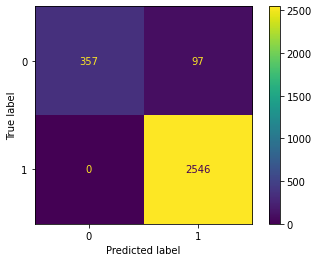

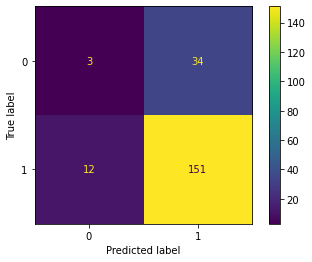

In [83]:
model, test_hists = build_model(optimal_hyperparameters)
test_prediction = model.predict(test_hists)
test_accuracy = np.mean(test_prediction == test_labels) * 100

training_prediction = model.predict(all_training_hists[optimal_hyperparameters["k"]])
training_accuracy = np.mean(training_prediction == training_labels) * 100

print("The accuracy of the model when tested on the testing dataset is {}%.".format(test_accuracy))
print("The accuracy of the model when tested on data it was trained on is {}%.".format(training_accuracy))
print("That is a discrepancy of {}%!".format(abs(training_accuracy - test_accuracy)))

print("The confusion matrices for the training and test set respectively are shown below:")

ConfusionMatrixDisplay.from_predictions(training_labels, training_prediction)
ConfusionMatrixDisplay.from_predictions(test_labels, test_prediction)

print("The classification report for the training dataset is given below:")
print(classification_report(training_labels, training_prediction))

print("The classification report for the test dataset is given below:")
print(classification_report(test_labels, test_prediction))

## Further Experimentation Area

Clearly, the 'optimal' model is considerably overfit as there is a large discrepancy between performance on the training set and the test set. I expect due to the degree of the polynomial in relation to the compartive small size of the dataset. To inspect this, we now look into the degree at which the polynomial kernel was evaluated.

To investigate this overfitting and what may be a better alternative to the model produced, we now evaluate more models with altered hyperparameters.

In [39]:
# As the accuracy above is much less than the cross validation score achieved, we need to address the dramatic overfitting. To this end, we will try some other arbitrary models:
for deg in range(1, 10):
    hyperparams = {
        "k" : 70,
        "c" : 0.01,
        "kernel" : "poly",
        "kernel_parameter" : deg
    }
    model, test_hists = build_model(hyperparams)
    prediction = model.predict(test_hists)
    print("Polynomial degree = {}, Accuracy =  {}.".format(deg, np.mean(prediction == test_labels)))

Polynomial degree = 1, Accuracy =  0.815.
Polynomial degree = 2, Accuracy =  0.815.
Polynomial degree = 3, Accuracy =  0.81.
Polynomial degree = 4, Accuracy =  0.8.
Polynomial degree = 5, Accuracy =  0.79.
Polynomial degree = 6, Accuracy =  0.79.
Polynomial degree = 7, Accuracy =  0.78.
Polynomial degree = 8, Accuracy =  0.775.
Polynomial degree = 9, Accuracy =  0.775.


Clearly, as shown by the output above, a linear SVM kernel is the most accurate. The accuracy of the models appear to degrade as a function of polynomial degree. To further investigate this, we trial some further models with linear kernels, as below.

The entire output of all the testing below is given as to demonstrate a point made in the next markdown cell.

Remember, all of the models evaluated below have **LINEAR** kernels.

In [41]:
for k in K_VALS:
    for c in [0.0001, 0.0005, 0.001, 0.005, 0.01]:
        hyperparams = {
            "k" : k,
            "c" : c,
            "kernel" : "poly",
            "kernel_parameter" : 1
        }
        model, test_hists = build_model(hyperparams)
        prediction = model.predict(test_hists)
        print("k = {}, C = {}, Accuracy = {}.".format(k, round(c, 5), np.mean(prediction == test_labels)))

k = 20, C = 0.0001, Accuracy = 0.815.
k = 20, C = 0.0005, Accuracy = 0.815.
k = 20, C = 0.001, Accuracy = 0.815.
k = 20, C = 0.005, Accuracy = 0.815.
k = 20, C = 0.01, Accuracy = 0.815.
k = 30, C = 0.0001, Accuracy = 0.815.
k = 30, C = 0.0005, Accuracy = 0.815.
k = 30, C = 0.001, Accuracy = 0.815.
k = 30, C = 0.005, Accuracy = 0.815.
k = 30, C = 0.01, Accuracy = 0.815.
k = 40, C = 0.0001, Accuracy = 0.815.
k = 40, C = 0.0005, Accuracy = 0.815.
k = 40, C = 0.001, Accuracy = 0.815.
k = 40, C = 0.005, Accuracy = 0.815.
k = 40, C = 0.01, Accuracy = 0.815.
k = 50, C = 0.0001, Accuracy = 0.815.
k = 50, C = 0.0005, Accuracy = 0.815.
k = 50, C = 0.001, Accuracy = 0.815.
k = 50, C = 0.005, Accuracy = 0.815.
k = 50, C = 0.01, Accuracy = 0.815.
k = 60, C = 0.0001, Accuracy = 0.815.
k = 60, C = 0.0005, Accuracy = 0.815.
k = 60, C = 0.001, Accuracy = 0.815.
k = 60, C = 0.005, Accuracy = 0.815.
k = 60, C = 0.01, Accuracy = 0.815.
k = 70, C = 0.0001, Accuracy = 0.815.
k = 70, C = 0.0005, Accuracy = 0

However, these model are "accurate" because they simply guess that each image has a tumour in it. (See cell below for a demonstration).
This is *very* incorrect!

k = 40, C = 0.01, Accuracy = 0.815.
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.81      1.00      0.90       163

    accuracy                           0.81       200
   macro avg       0.41      0.50      0.45       200
weighted avg       0.66      0.81      0.73       200



C:\Users\adama\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adama\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adama\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

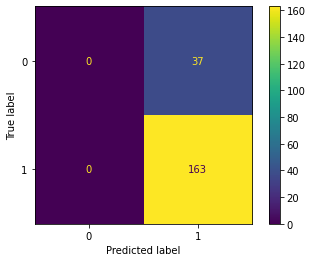

In [42]:
k = 40
c = 0.01

hyperparams = {
    "k" : k,
    "c" : c,
    "kernel" : "poly",
    "kernel_parameter" : 1
}
model, test_hists = build_model(hyperparams)
test_prediction = model.predict(test_hists)

print("k = {}, C = {}, Accuracy = {}.".format(k, round(c, 5), np.mean(test_prediction == test_labels)))

ConfusionMatrixDisplay.from_predictions(test_labels, test_prediction)
print(classification_report(test_labels, test_prediction))

Therefore, we can disregard this result. Our overfit model is performing relatively well on the unseen data at 77% accuracy. As above, models with other hyperparameters peform marginally better on the training data. See the cells below for a demonstration.

## Further Experimentation of Models with the Benefit of the Training Data.

See the next markdown cell for an import discussion!

The accuracy of the model when tested on the testing dataset is 77.0%.
The accuracy of the model when tested on data it was trained on is 96.76666666666667%.
That is a discrepancy of 19.766666666666666%!
The confusion matrices for the training and test set respectively are shown below:
The classification report for the training dataset is given below:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       454
           1       0.96      1.00      0.98      2546

    accuracy                           0.97      3000
   macro avg       0.98      0.89      0.93      3000
weighted avg       0.97      0.97      0.97      3000

The classification report for the test dataset is given below:
              precision    recall  f1-score   support

           0       0.20      0.08      0.12        37
           1       0.82      0.93      0.87       163

    accuracy                           0.77       200
   macro avg       0.51      0.50     

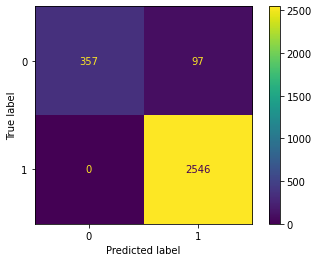

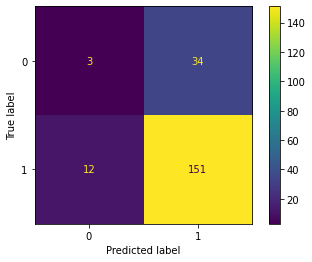

In [72]:
# The initial overfit but was evaluated before, but we will re-evaluate it here with the exact same code:

model, test_hists = build_model(optimal_hyperparameters)
test_prediction = model.predict(test_hists)
test_accuracy = np.mean(test_prediction == test_labels) * 100

training_prediction = model.predict(all_training_hists[optimal_hyperparameters["k"]])
training_accuracy = np.mean(training_prediction == training_labels) * 100

print("The accuracy of the model when tested on the testing dataset is {}%.".format(test_accuracy))
print("The accuracy of the model when tested on data it was trained on is {}%.".format(training_accuracy))
print("That is a discrepancy of {}%!".format(abs(training_accuracy - test_accuracy)))

print("The confusion matrices for the training and test set respectively are shown below:")

ConfusionMatrixDisplay.from_predictions(training_labels, training_prediction)
ConfusionMatrixDisplay.from_predictions(test_labels, test_prediction)

print("The classification report for the training dataset is given below:")
print(classification_report(training_labels, training_prediction))

print("The classification report for the test dataset is given below:")
print(classification_report(test_labels, test_prediction))

The accuracy of the model when tested on the testing dataset is 78.0%.
The accuracy of the model when tested on data it was trained on is 95.43333333333334%.
That is a discrepancy of 17.433333333333337%!
The confusion matrices for the training and test set respectively are shown below:
The classification report for the test dataset is given below:
              precision    recall  f1-score   support

           0       0.23      0.08      0.12        37
           1       0.82      0.94      0.87       163

    accuracy                           0.78       200
   macro avg       0.52      0.51      0.50       200
weighted avg       0.71      0.78      0.73       200



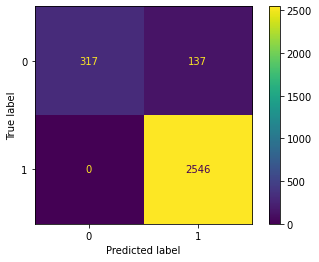

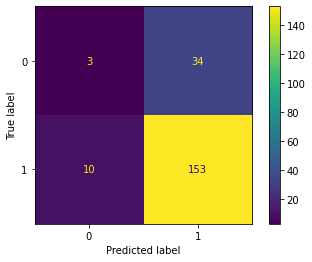

In [45]:
# Next, we perform the same analysis but with an arbitrary 'good' model

hyperparams = {
    "k" : 70,
    "c" : 0.01,
    "kernel" : "poly",
    "kernel_parameter" : 7
}
model, test_hists = build_model(hyperparams)
test_prediction = model.predict(test_hists)

model, test_hists = build_model(hyperparams)
test_prediction = model.predict(test_hists)
test_accuracy = np.mean(test_prediction == test_labels) * 100

training_prediction = model.predict(all_training_hists[hyperparams["k"]])
training_accuracy = np.mean(training_prediction == training_labels) * 100

print("The accuracy of the model when tested on the testing dataset is {}%.".format(test_accuracy))
print("The accuracy of the model when tested on data it was trained on is {}%.".format(training_accuracy))
print("That is a discrepancy of {}%!".format(abs(training_accuracy - test_accuracy)))

print("The confusion matrices for the training and test set respectively are shown below:")

ConfusionMatrixDisplay.from_predictions(training_labels, training_prediction)
ConfusionMatrixDisplay.from_predictions(test_labels, test_prediction)

print("The classification report for the test dataset is given below:")
print(classification_report(test_labels, test_prediction))

## Final Notes on the Models Produced

According to the evaluations above, the more the model guessed that a tumour was present in the image, the better it performed under the accuracy metric. Therefore, purely accuracy was not a good metric by which to measure the performance of the model. Some common metrics and precision and recall. These are explained further in the accompanying report. Unfortunately for the highest accuracy linear kernel model, its precision for the "no_tumour" category was 0 - as was it's recall.

Therefore, as the highly optimised model is at least slightly discriminatory, it can be deemed the best model found of the models assessed without the use of the test data set. Of course, as per the cell above, other arbitrary models performed better on the test data set. However, they did perform worse during the cross validation phase and hence were not selected at the training phase to be te best performing model found.

As a final note, we investigate the SVM convergence process below:

In [59]:
SVM_CONVERGENCE = np.arange(0, 10000, 500)

scores = []

for num in (SVM_CONVERGENCE):
    
    clear_output(wait = True)

    svc = SVC(C = 0.01, kernel = "poly", degree = 7, max_iter = num)
    
    scores.append(round(sum(cross_val_score(svc, all_training_hists[70], training_labels, cv = K_FOLD_CROSS_VALIDATION_K)) / K_FOLD_CROSS_VALIDATION_K, 5))


C:\Users\adama\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=9500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\adama\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=9500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\adama\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=9500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\adama\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=9500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users

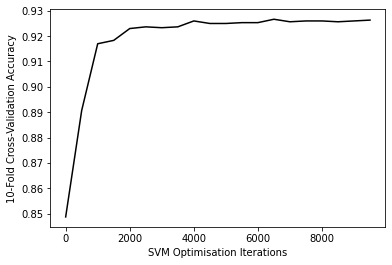

In [71]:
plt.plot(SVM_CONVERGENCE, scores, "k-")
plt.xlabel("SVM Optimisation Iterations")
plt.ylabel("10-Fold Cross-Validation Accuracy")
plt.show()

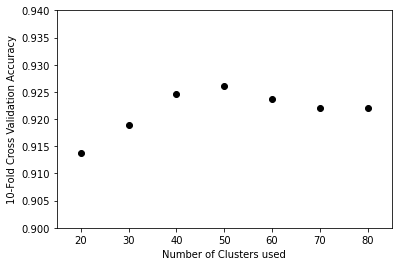

In [82]:
plt.plot(k_scores.keys(), k_scores.values(), "ko")
plt.xlim((15, 85))
plt.ylim((0.9, 0.94))
plt.xlabel("Number of Clusters used")
plt.ylabel("10-Fold Cross Validation Accuracy")
plt.savefig("123.png")
plt.show()